<a href="https://colab.research.google.com/github/nishzsche/nishzsche.github.io/blob/gh-pages/notebooks/EDA_on_Titanic_%7C_TOP_5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240603%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240603T171358Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3679f82808529ac23811c76d18693f3bf25f4bfa9c4e6f4c0a9fca873b94026e1783980dddcbe3f8fd3394a1443c185d61904736e4643061cabefaf1d82e9b0fea46d46b8270306408b287dec849edbd527d43fb715df1d49ceabe88d5902c77d6d0549af7efd6c6759c9a134ea957ca73bbac0f38b4cafaf1a21ff2d1760bdad469cb9f37b6c26df6ae77107667e9224e81f92ccf4ab7c739eb4439c4e614b520d831b8f97caa77d03f872b6c22aaedcae7523476de959eeaa8675ccb9b841e976ee52b7a67382f9ff95cd18a2691b75287b6b99078ac16a9ef18caf36212ddf1a108c2f73d8912786de807a706e35a611a9061bee4880cfd4c5ccbcbcc6129'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

# **Exploratory Data Analysis on Titanic Dataset**

In [ ]:
import random
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency,levene,kruskal
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xgboost import XGBClassifier

print("Setup Complete")

Setup Complete


In [ ]:
#Loading titanic data
train_data = pd.read_csv('/kaggle/input/titanic/train.csv',index_col='PassengerId')
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
#Basic Info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
#Statistical summary for numerical features
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
#Statistical Summary for object type features (categorical)
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Corn, Mr. Harry",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [ ]:
# Finding features containing NULL values
train_data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## What is a contingency table?

### Contingency Table Overview

A **contingency table**, also known as a cross-tabulation or crosstab, is a type of table in a matrix format that displays the (multivariate) frequency distribution of the variables. It is used extensively in statistics to analyze the relationship between two or more categorical variables.

### Structure of a Contingency Table

A simple contingency table is a two-dimensional matrix. Each row represents a category of one variable and each column represents a category of another variable. The cells of the table contain the counts or frequencies of observations that correspond to each row and column category combination.

### Simple Example

Imagine we have data from a survey where 100 people answered whether they like or dislike coffee and whether they are under or over 30 years old. The contingency table might look like this:

| Age/Coffee Preference | Like | Dislike |
|-----------------------|------|---------|
| Under 30              |  30  |   20    |
| Over 30               |  25  |   25    |

This table shows how different age groups have different preferences for coffee. For instance, 30 out of 50 people under 30 like coffee.

### Application in Data Science: Exploratory Data Analysis (EDA)

Contingency tables are highly valuable in exploratory data analysis (EDA) for several reasons:

1. **Relationship Assessment**:
   - They provide a clear way to observe relationships or associations between categorical variables.
   - By examining the frequencies, one can hypothesize whether or not there seems to be a dependency between the variables.

2. **Hypothesis Testing**:
   - Contingency tables are often used as a basis for statistical tests such as Chi-square tests, which help determine whether there are significant differences between subgroups.
   - This can be useful in hypothesis testing when deciding if variables are independent of each other or associated in some way.

3. **Data Quality Checks**:
   - Quick visualization of data distributions can help identify irregularities or potential errors in data collection or categorization, such as unusually high or low frequencies in certain combinations.

4. **Simplifying Data**:
   - By summarizing complex data sets into a comprehensible format, contingency tables facilitate a better and quicker understanding of the data, guiding further analysis steps.

In summary, contingency tables simplify complex data sets, making them easier to analyze and interpret, especially in the preliminary stages of data analysis. They serve as a powerful tool for spotting trends, testing theories, and making data-driven decisions in various fields, including marketing, healthcare, and social sciences.

In [ ]:
train_data.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

## What is P Values

### Understanding P-values

The **p-value** is a fundamental concept in statistical hypothesis testing, particularly in the context of deciding whether to reject a null hypothesis. It measures the probability of observing results at least as extreme as those in your data, assuming that the null hypothesis is true.

### Simple Explanation

The p-value tells you how likely you are to see your data, or something more extreme, if the null hypothesis of a study is true. If this probability (the p-value) is very low, it suggests that such extreme data would be very unusual under the null hypothesis. Therefore, a low p-value (typically less than 0.05) often leads researchers to reject the null hypothesis, concluding that the observed effect is statistically significant, i.e., likely not due to chance.

### Example Scenario: Coin Toss

Let's say you have a coin and you want to test whether it is fair (null hypothesis). You decide to flip it 100 times to see how many times it lands on heads. Suppose you observe 60 heads (which seems high for a fair coin).

You could use a statistical test (like a binomial test) to calculate the p-value — the probability of getting 60 or more heads in 100 tosses if the coin is indeed fair.

- **Hypothesis**:
  - Null hypothesis \( H_0 \): The coin is fair (p = 0.5).
  - Alternative hypothesis \( H_a \): The coin is not fair (p ≠ 0.5).

- **Calculation**:
  - Using the binomial distribution, calculate the probability of getting exactly 60, 61, ..., 100 heads. Sum these probabilities to find the total probability of getting at least 60 heads.

- **P-value**: Suppose this probability (summed up) comes out to be 0.04.

### Interpretation
- A p-value of 0.04 suggests that there is a 4% chance of observing 60 or more heads in 100 flips if the coin were fair.
- Since 0.04 is less than the typical threshold of 0.05, you might reject the null hypothesis, concluding there is statistically significant evidence that the coin may not be fair.

### Context in Data Science

In data science, p-values are used to determine the statistical significance of results obtained from models and tests. This can help in:
- **Model Feature Selection**: Determining which variables significantly predict an outcome.
- **A/B Testing**: Deciding if changes in a website or app significantly affect user behavior.
- **Medical Studies**: Assessing whether new treatments are effective.

Understanding and using p-values correctly is crucial as they help in making informed decisions based on statistical evidence. However, it's also important to use them in conjunction with other statistics like confidence intervals and effect sizes to get a complete picture of your study results.

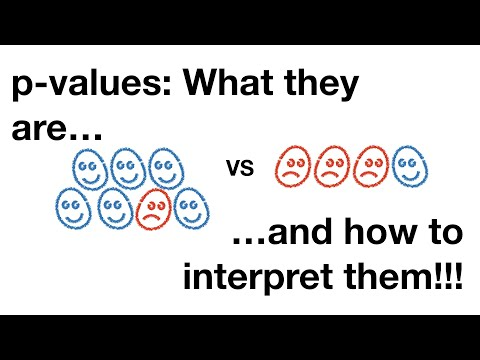

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('vemZtEM63GY', width=800, height=300)

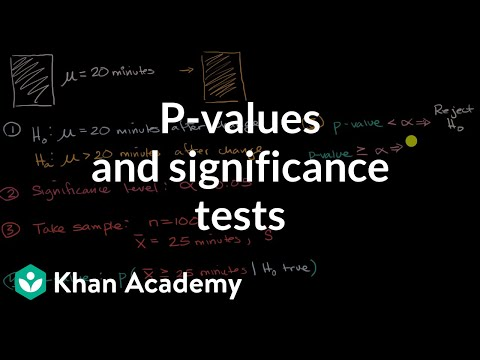

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('KS6KEWaoOOE', width=800, height=300)

Age       False  True 
Survived              
0           424    125
1           290     52
Age P Value: 0.007682742096212262


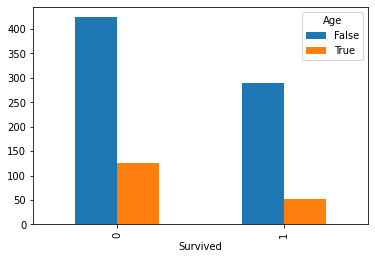

Cabin     False  True 
Survived              
0            68    481
1           136    206
Cabin P Value: 6.7419704360811776e-21


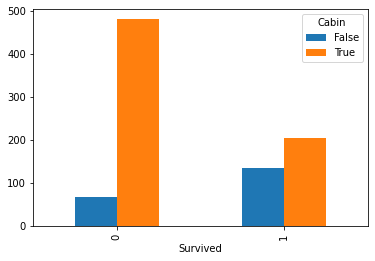

In [ ]:
# Checking effects of features cobtaining NULL values on target
# Embarked has 2 NULL values which isn't a significant amount
missing_feat = ['Age','Cabin']

for col in missing_feat:
    contigency_table = pd.crosstab(train_data['Survived'],train_data[col].isnull())
    p_value = chi2_contingency(contigency_table)[1]
    print(contigency_table)
    print(col,'P Value:',p_value)

    contigency_table.plot.bar()
    plt.show()

    Observation : Null values of Age and Cabin are strongly associated with Survived

## What is List Comprehension in Python

List comprehension is a concise and efficient way to create lists in Python. It allows you to generate new lists by applying an expression to each item in an iterable (like a list, tuple, etc.) and optionally filtering elements to include only those that meet certain conditions.

### Basic Syntax

The basic syntax of a list comprehension is:
```python
[expression for item in iterable]
```

### Simple Example

Here’s a basic example where we create a list of squares of numbers from 1 to 5:

```python
squares = [x**2 for x in range(1, 6)]
print(squares)  # Output: [1, 4, 9, 16, 25]
```

### Adding Conditional Logic

You can also add a condition to the list comprehension to filter elements. The syntax becomes:

```python
[expression for item in iterable if condition]
```

### Example with Condition

For instance, if you want a list of squares of only the even numbers from 1 to 10, you could do:

```python
even_squares = [x**2 for x in range(1, 11) if x % 2 == 0]
print(even_squares)  # Output: [4, 16, 36, 64, 100]
```

### Multiple For Loops

List comprehensions can also contain multiple `for` clauses, which is similar to using nested loops:

```python
# Example: Create a list of all possible (x, y) pairs where x is from 0 to 2 and y is from 0 to 2
pairs = [(x, y) for x in range(3) for y in range(3)]
print(pairs)
# Output: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
```

### Practical Application

List comprehensions are widely used in data science for data manipulation and transformation tasks, such as cleaning data, extracting information, or transforming data structures. They offer a more readable and expressive syntax compared to traditional loop and filter constructs.

### Example in Data Science

Imagine you have a list of temperatures in Celsius and you want to convert them to Fahrenheit:

```python
celsius = [0, 10, 20, 34.5]
fahrenheit = [((9/5) * temp + 32) for temp in celsius]
print(fahrenheit)  # Output: [32.0, 50.0, 68.0, 94.1]
```

### Conclusion

List comprehension is a powerful feature in Python that makes code more readable and often faster. It’s especially useful when you need to perform operations on list elements and can be extended to more complex data structures and operations, making it a valuable tool for any Python programmer.

In [ ]:
#Listing Descrete features and their unique values
discrete_feat = [col for col in train_data.columns if train_data[col].dtype != 'O' and
                 train_data[col].nunique()<25]

# Removing the target feature
discrete_feat.remove('Survived')

# Checking data distribution among descrete features
for feature in discrete_feat:
    print(train_data[[feature]].value_counts()/train_data.shape[0]*100)

Pclass
3         55.106622
1         24.242424
2         20.650954
dtype: float64
SibSp
0        68.237935
1        23.456790
2         3.142536
4         2.020202
3         1.795735
8         0.785634
5         0.561167
dtype: float64
Parch
0        76.094276
1        13.243547
2         8.978676
3         0.561167
5         0.561167
4         0.448934
6         0.112233
dtype: float64


    Observation: Sibsp and Parch having many categories with frequency less than 5%, we will combined them in a single category

In [ ]:
# Combining categories for SibSp and Parch and creating new features
data = train_data.copy()
data['FamilySize'] = data['Parch']+data['SibSp']+1
data['Parch'] = data['Parch'].replace({3:2,4:2,5:2,6:2})
data['SibSp'] = data['SibSp'].replace({3:2,4:2,5:2,8:2})
data['IsAlone'] = np.where((data.Parch ==0)& (data.SibSp ==0),1,0)
discrete_feat.extend(['IsAlone','FamilySize'])
print(data['Parch'].value_counts()/891*100)
print(data['SibSp'].value_counts()/891*100)

In [ ]:
#Checking effects of descrete features on target feature
for col in discrete_feat:
    contigency_table = pd.crosstab(data['Survived'],data[col])
    p_value = chi2_contingency(contigency_table)[1]
    print(contigency_table)
    print(col,':',p_value)

    contigency_table.plot.bar()
    plt.show()

    As you can see in the plots that the every feature has an association with survived feature

In [ ]:
#Listing continuous features
continuous_feat = [col for col in train_data.select_dtypes(exclude='O')
                   if train_data[col].nunique()>=25]

#Let's see continuous features distribution or they have any kind of skewness
for feature in continuous_feat:
    data  = train_data.copy()
    data[feature].hist()
    plt.title(feature)
    plt.show()
    print('Skew :',data[feature].skew())

In [ ]:
# Checking the outliers in Age
# copy the master data
data = train_data.copy()

# fill NaN values with median
data['Age'].fillna(data['Age'].median(),inplace=True)

# printing the after using log
print('Skew :',data['Age'].skew())

# finding the interquatile range for detecting outliers
ior = data['Age'].quantile(.75)-data['Age'].quantile(.25)

# setting the lower and upper bounds
lower_b = data['Age'].quantile(0.25)-ior*1.5
lower_b = 0 if lower_b < 0 else lower_b
upper_b = data['Age'].quantile(0.75)+ior*1.5

# printing lower and upper bounds
print('Lower bound :',lower_b,'\nUpper bound :',upper_b)

# counting the outliers in data
data['Age'] = np.where((data['Age'] > lower_b) & (data['Age'] < upper_b),0,1 )
print('Outliers in Age',len(data[data['Age']==1]))
print('Overview of outliers\n',sorted(train_data.loc[data['Age'] == 1,'Age']))

    Observation: Outliers in Age are valid data points

In [ ]:
  # copy the master data
data = train_data.copy()

# Converting <=0 value to 1 for log operation
data.loc[data['Fare']<=0,'Fare'] = 1

# printing the before using log
print('before log :',data['Fare'].skew())

# converting the data using log
data.Fare = np.log(data.Fare)

# printing the after using log
print('after log :',data['Fare'].skew())

# finding the interquatile range for detecting outliers
ior = data['Fare'].quantile(.75)-data['Fare'].quantile(.25)

# setting the lower and upper bounds
lower_b = data['Fare'].quantile(0.25)-ior*1.5
lower_b = 0 if lower_b < 0 else lower_b
upper_b = data['Fare'].quantile(0.75)+ior*1.5

# printing lower and upper bounds
print('Lower bound :',lower_b,'\nUpper bound :',upper_b)

# counting the outliers in data
data['Fare'] = np.where((data['Fare'] > lower_b) & (data['Fare'] < upper_b),0,1 )
print('Outliers in Fare',len(data[data['Fare']==1]))
print('Overview of outliers\n',sorted(train_data.loc[data['Fare'] == 1,'Fare']))

    Observation: we need to winsorized the upper tail

In [ ]:
#Checking effects of continuous features on target feature
for col in continuous_feat:
    data = train_data.copy()
    data[col].fillna(data[col].median(),inplace=True)
    data['bin'] = pd.qcut(data[col],q=6,duplicates='drop')
    contigency_table = pd.crosstab(data['bin'],data['Survived'])

    x = data[data.Survived==0][col]
    y = data[data.Survived==1][col]

    _,lp_value = levene(x,y)
    _,p_value = kruskal(x,y)
    chi2_p_value = chi2_contingency(contigency_table)[1]

    print('Levene P-Value:',lp_value)
    print('Kruskal P-Value:',p_value)
    print('Contigency Table P Value:',chi2_p_value)

    plt.figure(figsize=(16,12))

    plt.subplot(121)
    plt.boxplot(x=[x,y],labels=['Not Survived','Survived'],showmeans=True)
    plt.title(col)

    ax = plt.subplot(122)
    contigency_table.plot.bar(ax=ax)
    plt.title(col)
    plt.show()

    Observation:  Significant association between the Age bins and survival suggests that the binning process captures meaningful information related to survival outcomes, even if there are no significant differences in median values between survival groups.
    
        For Fare both the continuous and binned values captures meaningful insights related to survival outcomes.

In [ ]:
#Getting Categorical Features and printing number of their unique value
categorical_feat = [col for col in train_data.select_dtypes(include='O')]

for col in categorical_feat:
    print(col,' : ',train_data[col].nunique())

In [ ]:
#Checking Name feature effects on target feature
data=train_data.copy()

# Extracting out the title like Mr. Miss. etc.
data['Name'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
social_status_mapping = {
    'Capt': 'Rare',
    'Col': 'Rare',
    'Don': 'Rare',
    'Dona': 'Rare',
    'Dr': 'Rare',
    'Jonkheer': 'Rare',
    'Lady': 'Rare',
    'Major': 'Rare',
    'Mlle': 'Miss',
    'Mme': 'Miss',
    'Mrs':'Miss',
    'Ms': 'Miss',
    'Rev': 'Rare',
    'Sir': 'Rare',
    'the Countess': 'Rare'
}

data['Name'] = data['Name'].replace(social_status_mapping)

#Ploting the data and see the correlation
contigency_table = pd.crosstab(data['Name'],data['Survived'])
plt.figure(figsize=(8,6))
data.groupby('Name')['Survived'].mean().plot.bar(ax=plt.gca())
plt.title('Name(Title)')
plt.show()

print('P Value:',chi2_contingency(contigency_table)[1])
contigency_table

    Observation: Title having significant association with the survival outcome

In [ ]:
#Checking Sex feature effects on target feature
data=train_data.copy()

#Ploting the data and see the correlation
contigency_table = pd.crosstab(data['Sex'],data['Survived'])
plt.figure(figsize=(12,9))
contigency_table.plot.bar(ax=plt.gca())
plt.title('Sex')
plt.show()

print('P Value:',chi2_contingency(contigency_table)[1])
contigency_table

    Observation: It was obvious that gender plays a crusial role in survival outcome, Gender may have a correlation with titles

In [ ]:
#Checking Ticket effect on target feature
# coping the master data
data = train_data.copy()

#Creating dictionary holding head count per ticket
head_count = pd.Series(train_data.groupby('Ticket')['Name'].count()).to_dict()
head_count = {key:3 if val>=3 else val for key,val in head_count.items()}

#Creating new feature to map the head count
data['TicketHeadCount'] = data['Ticket'].map(head_count)

# ploting the data and see the correlation
plt.figure(figsize=(12,9))
contigency_table = pd.crosstab(data['TicketHeadCount'],data['Survived'])
contigency_table.plot.bar(ax=plt.gca())
plt.show()

print('P value:',chi2_contingency(contigency_table)[1])
contigency_table

    Observation: Ticket head count bins are divided in 3 groups as 1(unique ticket),2(2 persons), 3(more than 2 persons)

In [ ]:
#Checking Cabin effect on target feature
# copy the master data
data = train_data.copy()

#Extract Cabin class
data.Cabin = data.Cabin.str.get(0)
# data.Cabin = data.Cabin.fillna('NA')

# ploting the data find the correlation with survivers
contigency_table = pd.crosstab(data['Cabin'],data['Survived'])
plt.figure(figsize=(12,9))
contigency_table.plot.bar(ax=plt.gca())
plt.show()

print('P value:',chi2_contingency(contigency_table)[1])
contigency_table

    Observation: Cabin classes with P value 0.17(>0.05) may not associated with survival octcomes

In [ ]:
#Checking Embarked feature effects on target feature
data=train_data.copy()

# Filling NA with the mode of the distribution (only 2 NA are present)
data['Embarked'].fillna('S',inplace=True)

#Ploting the data and see the correlation
contigency_table = pd.crosstab(data['Embarked'],data['Survived'])
plt.figure(figsize=(12,9))
contigency_table.plot.bar(ax=plt.gca())
plt.show()

print('P value:',chi2_contingency(contigency_table)[1])
contigency_table

    Observation: most people Embarked from S(Southampton) where people having lowest survival ratio and C(Cherbourg) having most survival ratio

## **Data Preprocessing**
- **Handle Missing Data:**
     Address missing values through imputation or removal.

- **Data Cleaning:**
    Clean and format the data, handling outliers and inconsistencies.

- **Feature Engineering:**
    Create new features or transform existing ones to enhance model performance.


In [ ]:
# Loading Training and Test data
train_data = pd.read_csv('/kaggle/input/titanic/train.csv',index_col='PassengerId')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv',index_col='PassengerId')
combined_data = [train_data,test_data]

In [ ]:
# Imputing Missing values
for data in combined_data:
    # Extracting title from the Names
    data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

    # Creating new feature indicating age null values and
    # Imputing missing values with the median age of the indivisual group base on 'Title' and 'Pclass'
    data['AgeIsNull'] = np.where(data['Age'].isnull(),1,0)
    age = data.groupby(['Title','Pclass'])['Age'].transform('median').fillna(data['Age'].median())
    data['Age'] = np.where(data.Age.isnull(),age,data.Age)

    # Imputing missing values with median (Only 1 missing value in test data)
    data['Fare'] = data['Fare'].fillna(data.Fare.median())

    # Creating new feature indicating Cabin null values and
    #  Imputing missing values with NA
    data['CabinIsNull'] = np.where(data['Cabin'].isnull(),1,0)
    data['Cabin'] = data['Cabin'].fillna('NA')

    # Imputing missing values with mode value which is 'S' (Only 2 missing value in train data)
    data['Embarked'] = data['Embarked'].fillna('S')

In [ ]:
# Formating categorical features
for data in combined_data:
    # Formating Title to numerical form
    data['Title'] = data['Title'].replace(social_status_mapping)

    # Converting male/female to 1/0
    data['Sex'] = data['Sex'].replace({'female':0,'male':1})

    #Creating dictionary holding head count per ticket
    head_count = pd.Series(data.groupby('Ticket')['Name'].count()).to_dict()

    # Creating new feature to map the head count
    data['TicketHeadCount'] = data['Ticket'].replace(head_count)


In [ ]:
# Formating Numerical features
for data in combined_data:
    # Converting Age to 16 bins base on percentile
    data['AgeBin'] = pd.qcut(data['Age'],q=6,duplicates='drop',labels=False)

    # Converting Fare to 30 bins base on percentile
    data['FareBin'] = pd.qcut(data['Fare'],q=6,duplicates='drop',labels=False)

    # creating if the person travelling alone or not
    data['IsAlone'] = np.where((data.Parch ==0)& (data.SibSp ==0),1,0)
    data['FamilyMember'] = data['SibSp']+data['Parch']+1

In [ ]:
# Performing One Hot Encoding on Training and Test data
train_data = pd.get_dummies(train_data,columns=["Title","Embarked",'AgeBin','FareBin'],prefix=["Title","Emb",'Age','Fare'])
test_data = pd.get_dummies(test_data,columns=["Title","Embarked",'AgeBin','FareBin'],prefix=["Title","Emb",'Age','Fare'])

In [ ]:
# Dropping Unnecessary features
drop = ['Name', 'Age', 'Ticket', 'Fare', 'Cabin']
train_data.drop(drop,inplace=True,axis=1)
test_data.drop(drop,inplace=True,axis=1)

In [ ]:
# Ploting correlation heatmap
corr = train_data.drop('Survived',axis=1).corr()
plt.figure(figsize=(16,16))
sns.heatmap(data=abs(corr),annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Plotting correlaton with target feature
survived = train_data.Survived
plt.figure(figsize=(10,6))
corr = train_data.drop('Survived',axis=1).corrwith(survived)
corr = abs(corr)
corr.sort_values(ascending=False,inplace=True)
ax = corr.plot.bar(rot = 40)

    Observation: to Remove multicollinearity issue we are going to drop few highly correlated features

In [ ]:
# Removing features which are highly correlated(>0.7)
d_features = ['Survived','Title_Miss','Sex','CabinIsNull','Parch','SibSp','TicketHeadCount'
             ,'Emb_S']
# Ploting correlation heatmap
corr = train_data.drop(d_features,axis=1).corr()
plt.figure(figsize=(16,16))
sns.heatmap(data=abs(corr)>=0.7,annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Dropping the features from the test and train data
train_data.drop(d_features[1:],axis=1,inplace=True)
test_data.drop(d_features[1:],axis=1,inplace=True)

In [ ]:
# Fitting in Regression model to check relationship of survival outcomes with the features
model = sm.OLS(train_data.Survived,train_data.drop(['Survived'],axis=1)).fit()
model.summary()

    Observation: By observing the summary we can say who have paid higher fare have higher chance of survival. Where Age group 3 has the highest change of survival and Age group 5 has lowest

In [ ]:
# Only taking first 12 features for model fitiing
corr = train_data.drop('Survived',axis=1).corrwith(survived)
corr = abs(corr)
corr.sort_values(ascending=False,inplace=True)
final_features = corr.index[:12]

## **Final Fitting and Submission**

In [ ]:
model = XGBClassifier(objective='binary:logistic',
                      n_estimators = 100,
                      learning_rate=0.02,
                      max_depth=7,
                      gamma=0.2,
                      reg_alpha=0.5,
                      min_child_weight=10,
                      n_jobs=5)

acc_score = cross_val_score(model,
                            train_data.drop('Survived',axis=1)[final_features],
                            train_data.Survived,
                            scoring='accuracy')
print(acc_score.mean()*100)

In [ ]:
model.fit(train_data.drop('Survived',axis=1)[final_features],train_data.Survived)
pred = model.predict(test_data[final_features])

In [ ]:
output = pd.DataFrame({'PassengerId':test_data.index,'Survived':pred})
output.to_csv('/kaggle/working/submission.csv',index=False)